In [1]:
# import the necessary packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.model_selection import learning_curve
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import time

In [2]:
LEARNER_TITLE = 'Decision Tree'
LEARNER = 'decision_tree'
COLOR_HISTOGRAMS = 'color histogram'
PIXELS = 'pixels'
K = 5
CRITERION = 'entropy', 'gini', 'log_loss'
INPUT_TYPES = PIXELS, COLOR_HISTOGRAMS
COLORS = {
    'entropy': 'green',
    'gini': 'red',
    'log_loss': 'blue'
}
LINE_TYPES = {
    PIXELS: '-',
    COLOR_HISTOGRAMS: '--'
}

In [3]:
def image_to_feature_vector(image, size=(32, 32)):
	# resize the image to a fixed size, then flatten the image into
	# a list of raw pixel intensities
	return cv2.resize(image, size).flatten()

In [4]:
def extract_color_histogram(image, bins=(8, 8, 8)):
	# extract a 3D color histogram from the HSV color space using
	# the supplied number of `bins` per channel
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
		[0, 180, 0, 256, 0, 256])
	# handle normalizing the histogram if we are using OpenCV 2.4.X
	if imutils.is_cv2():
		hist = cv2.normalize(hist)
	# otherwise, perform "in place" normalization in OpenCV 3 (I
	# personally hate the way this is done
	else:
		cv2.normalize(hist, hist)
	# return the flattened histogram as the feature vector
	return hist.flatten()

In [5]:
df_dict = {
    'train': pd.read_csv('../dataset/dataframes/train.csv'),
    'test': pd.read_csv('../dataset/dataframes/test.csv'),
}

In [6]:
df = pd.concat(df_dict.values())

In [7]:
df['set'].unique()

array(['set_2', 'set_3', 'set_4', 'set_1'], dtype=object)

In [8]:
# loop over the input images
images = []
features = []
labels = []
print(len(df))
for i, row in tqdm(df.iterrows()):
	# load the image and extract the class label (assuming that our
	# path as the format: /path/to/dataset/{class}.{image_num}.jpg
	image = cv2.imread(row['path'])
	label = row['label']
	# extract raw pixel intensity "features", followed by a color
	# histogram to characterize the color distribution of the pixels
	# in the image
	pixels = image_to_feature_vector(image)
	hist = extract_color_histogram(image)
	# update the raw images, features, and labels matricies,
	# respectively
	set_str = row['set']
	images.append(pixels)
	features.append(hist)
	labels.append(label)

1280


1280it [00:01, 795.47it/s]


In [9]:
images = np.array(images)
features = np.array(features)
labels = np.array(labels)

print("[INFO] pixels matrix: {:.2f}MB".format(images.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {:.2f}MB".format(features.nbytes / (1024 * 1000.0)))

[INFO] pixels matrix: 3.84MB
[INFO] features matrix: 2.56MB


In [10]:
kf = KFold(K)
kf.shuffle = True

In [11]:
estimator_dict = {}
for criterion in CRITERION:
    estimator_dict[criterion] = DecisionTreeClassifier(criterion=criterion)

In [12]:
inputs = {COLOR_HISTOGRAMS: features, PIXELS: images}
common_params_dict = {}
for input_type, X in inputs.items():
    common_params_dict[input_type] = {
        "X": X,
        "y": labels,
        "train_sizes": np.linspace(0.1, 1.0, 5),
        "cv": kf,
        "n_jobs": 4,
        "return_times": True,
    }

In [13]:
train_sizes_dict = {}
train_scores_dict = {}
test_scores_dict = {}
fit_times_dict = {}
score_times_dict = {}

for criterion, estimator in estimator_dict.items():

    train_sizes_dict[criterion] = {}
    train_scores_dict[criterion] = {}
    test_scores_dict[criterion] = {}
    fit_times_dict[criterion] = {}
    score_times_dict[criterion] = {}

    for input_type, common_params in common_params_dict.items():
        train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(estimator, **common_params)

        train_sizes_dict[criterion][input_type] = train_sizes
        train_scores_dict[criterion][input_type] = train_scores
        test_scores_dict[criterion][input_type] = test_scores
        fit_times_dict[criterion][input_type] = fit_times
        score_times_dict[criterion][input_type] = score_times

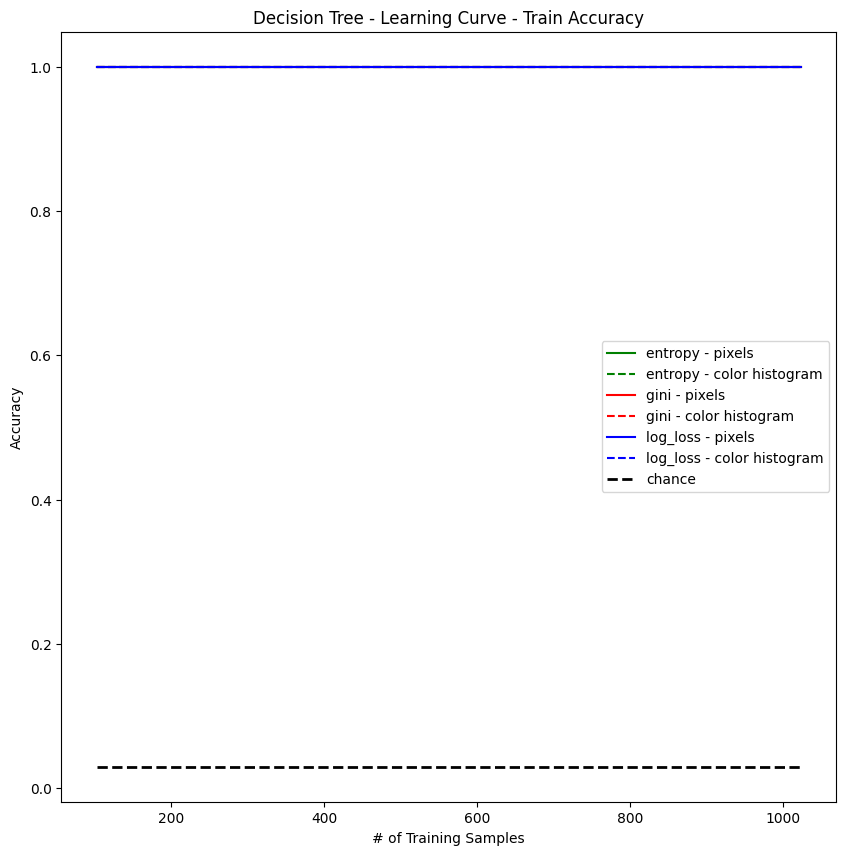

In [14]:
plt.figure(figsize=(10, 10))

min_x = np.inf
max_x = -np.inf
for criterion in CRITERION:
    for input_type in INPUT_TYPES:
        train_sizes = train_sizes_dict[criterion][input_type]
        train_scores = train_scores_dict[criterion][input_type]
        max_x = max(max_x, train_sizes.max())
        min_x = min(min_x, train_sizes.min())

        plt.plot(train_sizes, train_scores.mean(axis=1), LINE_TYPES[input_type], color=COLORS[criterion], label=f"{criterion} - {input_type}")

plt.plot([min_x, max_x], [0.03, 0.03], '--', color='black', label='chance', linewidth=2)
plt.xlabel("# of Training Samples")
plt.ylabel("Accuracy")
plt.title(f"{LEARNER_TITLE} - Learning Curve - Train Accuracy")
plt.legend()
plt.savefig(f'results/{LEARNER}_train_accuracy.png')

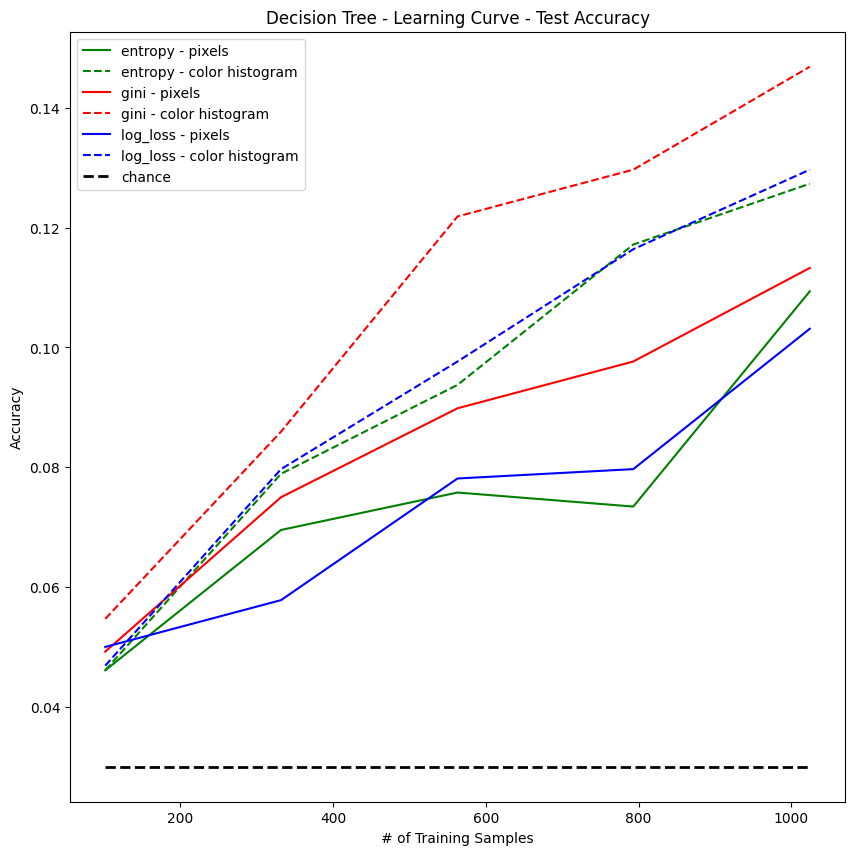

In [15]:
plt.figure(figsize=(10, 10))

min_x = np.inf
max_x = -np.inf
for criterion in CRITERION:
    for input_type in INPUT_TYPES:
        train_sizes = train_sizes_dict[criterion][input_type]
        test_scores = test_scores_dict[criterion][input_type]
        max_x = max(max_x, train_sizes.max())
        min_x = min(min_x, train_sizes.min())

        plt.plot(train_sizes, test_scores.mean(axis=1), LINE_TYPES[input_type], color=COLORS[criterion], label=f"{criterion} - {input_type}")

plt.plot([min_x, max_x], [0.03, 0.03], '--', color='black', label='chance', linewidth=2)
plt.xlabel("# of Training Samples")
plt.ylabel("Accuracy")
plt.title(f"{LEARNER_TITLE} - Learning Curve - Test Accuracy")
plt.legend()
plt.savefig(f'results/{LEARNER}_test_accuracy.png')

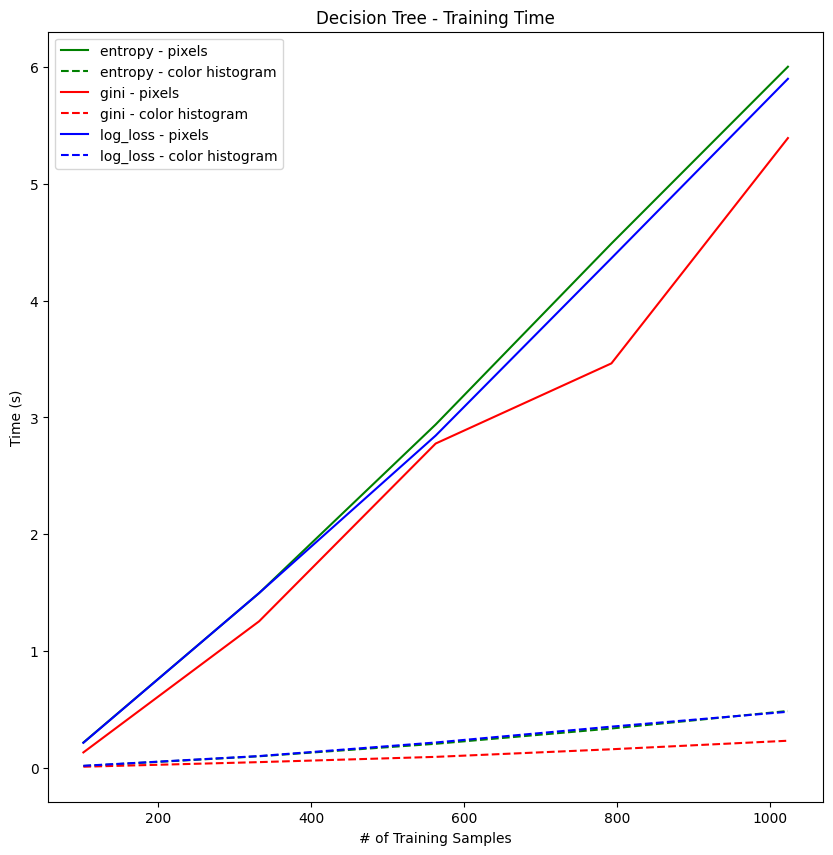

In [16]:
plt.figure(figsize=(10, 10))

for criterion in CRITERION:
    for input_type in INPUT_TYPES:

        train_sizes = train_sizes_dict[criterion][input_type]
        fit_times = fit_times_dict[criterion][input_type]

        plt.plot(train_sizes, fit_times.mean(axis=1), LINE_TYPES[input_type], color=COLORS[criterion], label=f"{criterion} - {input_type}")

plt.xlabel("# of Training Samples")
plt.ylabel("Time (s)")
plt.title(f"{LEARNER_TITLE} - Training Time")
plt.legend()
plt.savefig(f'results/{LEARNER}_training_time.png')

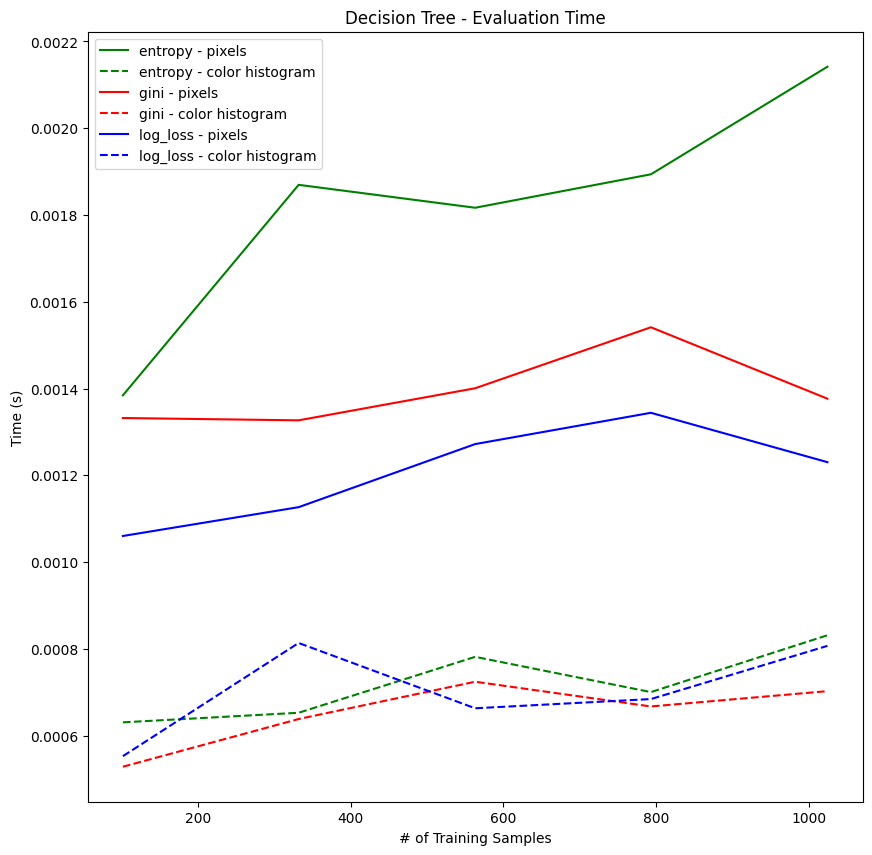

In [17]:
plt.figure(figsize=(10, 10))

for criterion in CRITERION:
    for input_type in INPUT_TYPES:

        train_sizes = train_sizes_dict[criterion][input_type]
        score_times = score_times_dict[criterion][input_type]

        plt.plot(train_sizes, score_times.mean(axis=1), LINE_TYPES[input_type], color=COLORS[criterion], label=f"{criterion} - {input_type}")

plt.xlabel("# of Training Samples")
plt.ylabel("Time (s)")
plt.title(f"{LEARNER_TITLE} - Evaluation Time")
plt.legend()
plt.savefig(f'results/{LEARNER}_evaluation_time.png')